In [2]:
# %pip install pandas matplotlib numpy seaborn scikit-learn xgboost lightgbm
# %pip install bayesian-optimization

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import ARDRegression

### 1. 전처리, 피처공학

In [4]:
# # Data Preprocessing
import pandas as pd
import numpy as np

data = pd.read_csv('../DATA/raw_2023051820231018_경대기업맞춤형.csv')
print('기본 데이터 shape :', data.shape)

# 2) scale_pv < 5, E_scr_pv == 8, k_rpm_pv > 50
data = data[data['scale_pv'] < 5]  # 약 1800개 제거
print('scale_pv < 5 shape :', data.shape)
data = data[data['E_scr_pv'] == 8]  # 약 3800개 제거
print('E_scr_pv == 8 shape :', data.shape)
data = data[data['k_rpm_pv'] > 50] # 약 170개 제거
print('k_rpm_pv > 100 shape :', data.shape)

# 3) E_scr_sv, c_temp_sv, n_temp_sv, s_temp_sv, k_rpm_sv, n_temp_sv 제거
data.drop(['E_scr_sv', 'E_scr_pv', 'c_temp_sv', 's_temp_sv', 'k_rpm_sv', 'n_temp_sv', 'Unnamed: 12'], axis=1, inplace=True)

data['time'] = pd.to_datetime(data['time'])
oct_data = data[data['time'].dt.month == 10]
oct_data = oct_data.drop('time', axis=1)
print('oct_data shape :', oct_data.shape)

train_data = data[data['time'].dt.month != 10]
train_data = train_data.drop('time', axis=1)
print('train_data shape :', train_data.shape)

기본 데이터 shape : (235413, 13)
scale_pv < 5 shape : (233676, 13)
E_scr_pv == 8 shape : (229983, 13)
k_rpm_pv > 100 shape : (229810, 13)
oct_data shape : (29651, 5)
train_data shape : (200159, 5)


### 스케일링 X. 증강 X

In [5]:
# 2 < scale_pv < 4
train_data_2_4 = train_data[(train_data['scale_pv'] > 2) & (train_data['scale_pv'] < 4)]
oct_data_2_4 = oct_data[(oct_data['scale_pv'] > 2) & (oct_data['scale_pv'] < 4)]

X_train = train_data_2_4.drop('scale_pv', axis=1)
y_train = train_data_2_4['scale_pv']
X_test = oct_data_2_4.drop('scale_pv', axis=1)
y_test = oct_data_2_4['scale_pv']


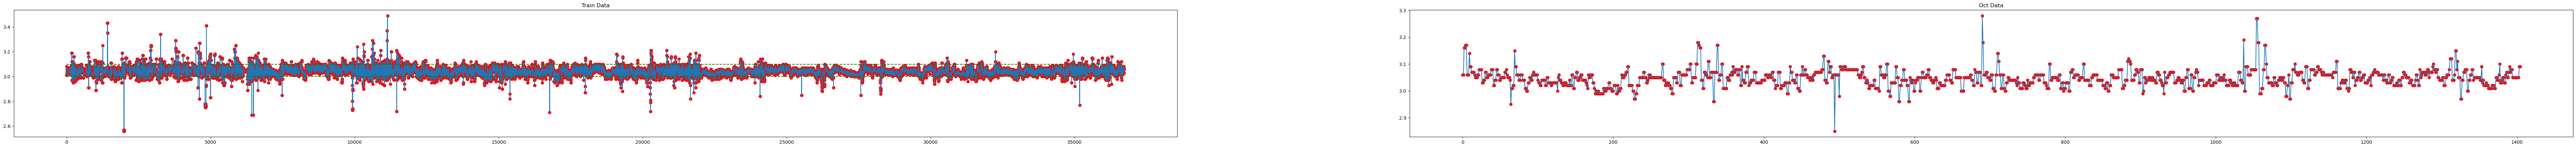

In [16]:
# scale_pv 범위 확인
train_data_2_4['scale_pv'].describe(), oct_data_2_4['scale_pv'].describe()

from matplotlib import pyplot as plt
plt.figure(figsize=(100, 5))
plt.subplot(1, 2, 1)
plt.plot(train_data_2_4['scale_pv'].reset_index(drop=True))
plt.scatter(range(len(train_data_2_4)), train_data_2_4['scale_pv'], c='r')
plt.hlines(3, 0, len(train_data_2_4), colors='g', linestyles='dashed')
plt.hlines(3.1, 0, len(train_data_2_4), colors='g', linestyles='dashed')
plt.title('Train Data')
plt.subplot(1, 2, 2)
plt.plot(oct_data_2_4['scale_pv'].reset_index(drop=True))
plt.scatter(range(len(oct_data_2_4)), oct_data_2_4['scale_pv'], c='r')
plt.title('Oct Data')
plt.show()


In [7]:
# [ cross_val_score 사용은 보류]
# 모델별 성능 확인
# 모델 리스트
models = [
    ('LinearRegression', LinearRegression()),
    ('Lasso', Lasso()),
    ('Ridge', Ridge()),
    ('BayesianRidge', BayesianRidge()),
    ('ElasticNet', ElasticNet()),
    # ('SGDRegressor', SGDRegressor()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ('AdaBoostRegressor', AdaBoostRegressor()),
    ('LGBMRegressor', LGBMRegressor()),
    ('ARDRegression', ARDRegression())
]

scalers = [
    ('NoScaler', None),
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RobustScaler', RobustScaler())
]

score_list = []

for s_name, scaler in scalers:
    for name, model in models:
        
        pipeline = Pipeline([
            ('scaler', scaler),
            ('model', model)
        ])
        mae_scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
        mape_scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=5)
        
        score_list.append([s_name, name, mae_scores.mean(), mape_scores.mean()])
        
print('score_list :', score_list)
score_list

KeyboardInterrupt: 

In [ ]:
# DataFrame으로 변환
score_df = pd.DataFrame(score_list, columns=['scaler', 'model', 'mae', 'mape'])
score_df

,scaler,model,mae,mape
0,StandardScaler,LinearRegression,-0.025878,-0.008524
1,StandardScaler,Lasso,-0.026316,-0.008663
2,StandardScaler,Ridge,-0.025878,-0.008524
3,StandardScaler,BayesianRidge,-0.025878,-0.008524
4,StandardScaler,ElasticNet,-0.026316,-0.008663
5,StandardScaler,RandomForestRegressor,-0.031630,-0.010404
6,StandardScaler,GradientBoostingRegressor,-0.026971,-0.008870
7,StandardScaler,AdaBoostRegressor,-0.030271,-0.010994
8,StandardScaler,LGBMRegressor,-0.027699,-0.009120
9,StandardScaler,ARDRegression,-0.026316,-0.008663


In [ ]:
# 스케일링 없이 데이터 학습 및 분석
# pipeline


# 모델 리스트
models = [
    ('LinearRegression', LinearRegression()),
    ('Lasso', Lasso()),
    ('Ridge', Ridge()),
    ('BayesianRidge', BayesianRidge()),
    ('ElasticNet', ElasticNet()),
    # ('SGDRegressor', SGDRegressor()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ('AdaBoostRegressor', AdaBoostRegressor()),
    ('LGBMRegressor', LGBMRegressor()),
    ('ARDRegression', ARDRegression())
]



    
    
    
# 모델별 성능 확인
score_df = pd.DataFrame(columns=['scaler', 'model', 'MAE', 'MAPE', 'R2'])

def feature_importance_finder(model, data):
    # 모델의 최고 feature_importance의 이름을 반환
    if hasattr(model, 'feature_importances_'):
        return data.columns[model.feature_importances_.argmax()]
    elif hasattr(model, 'coef_'):
        return data.columns[model.coef_.argmax()]
    else:
        return 'None'

for name, model in models:
    # StandardScaler 미사용
    pipeline = Pipeline([
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    diff = y_test - y_pred
    
    score_df = pd.concat(
        [score_df, 
         pd.DataFrame(
            [['None',
              name, 
              mean_absolute_error(y_test, y_pred), 
              mean_absolute_percentage_error(y_test, y_pred)*100, 
              r2_score(y_test, y_pred),
              diff.mean(), diff.std(), diff.max(), diff.min(), diff.median(),
              feature_importance_finder(pipeline.named_steps['model'], X_train)
            ]],
            columns=['scaler', 'model', 'MAE', 'MAPE', 'R2', 'diff_mean', 'diff_std', 'diff_max', 'diff_min', 'diff_median', 'feature_importance'])])
     

for name, model in models:
    # StandardScaler 사용
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    # print(f'[ {name} ]')
    # print('MAE :', mean_absolute_error(y_test, y_pred))
    # print('MAPE :', mean_absolute_percentage_error(y_test, y_pred)*100)
    # print('R2 :', r2_score(y_test, y_pred))
    
    diff = y_test - y_pred
    
    # score_df에 저장 : concat
    score_df = pd.concat(
        [score_df, 
         pd.DataFrame(
            [[str(pipeline.named_steps['scaler']),
              name, 
              mean_absolute_error(y_test, y_pred), 
              mean_absolute_percentage_error(y_test, y_pred)*100, 
              r2_score(y_test, y_pred),
              diff.mean(), diff.std(), diff.max(), diff.min(), diff.median(),
              feature_importance_finder(pipeline.named_steps['model'], X_train)
            ]],
            columns=['scaler', 'model', 'MAE', 'MAPE', 'R2', 'diff_mean', 'diff_std', 'diff_max', 'diff_min', 'diff_median', 'feature_importance'])])
    
score_df

LinearRegression : -0.025878434970383134
Lasso : -0.026316461854652272
Ridge : -0.025878427909274287
BayesianRidge : -0.025877769895710508
ElasticNet : -0.026316461854652272
RandomForestRegressor : -0.03161185707650886
GradientBoostingRegressor : -0.026977397503894517
AdaBoostRegressor : -0.0351153588168442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 29376, number of used features: 4
[LightGBM] [Info] Start training from score 3.040769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of 

C:\Users\wjs31\AppData\Local\Temp\ipykernel_2616\3945227027.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 36720, number of used features: 4
[LightGBM] [Info] Start training from score 3.041614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 36720, number of used features: 4
[LightGBM] [Info] Start training from score 3.041614


,scaler,model,MAE,MAPE,R2,diff_mean,diff_std,diff_max,diff_min,diff_median,feature_importance
0,None,LinearRegression,0.023703,0.774473,0.013737,0.009337,0.030945,0.218106,-0.182137,0.009348,n_temp_pv
0,None,Lasso,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv
0,None,Ridge,0.023703,0.774475,0.013734,0.009338,0.030945,0.218106,-0.182137,0.009348,n_temp_pv
0,None,BayesianRidge,0.023710,0.774689,0.013247,0.009363,0.030945,0.218172,-0.182093,0.009399,n_temp_pv
0,None,ElasticNet,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv
0,None,RandomForestRegressor,0.028098,0.919954,-0.326387,0.004776,0.037180,0.233700,-0.198210,0.004100,n_temp_pv
0,None,GradientBoostingRegressor,0.023807,0.778420,-0.005197,0.007723,0.031705,0.217014,-0.213104,0.007059,k_rpm_pv
0,None,AdaBoostRegressor,0.026187,0.854837,-0.212565,0.014076,0.032959,0.232628,-0.205824,0.010896,k_rpm_pv
0,None,LGBMRegressor,0.024335,0.796186,-0.031141,0.005449,0.032598,0.214798,-0.202663,0.004949,k_rpm_pv
0,None,ARDRegression,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv


In [ ]:
# %pip install bayesian-optimization

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR

from bayes_opt import BayesianOptimization

def svr_cv(C, gamma, data, targets):
    estimator = SVR(C=C, gamma=gamma)
    cval = cross_val_score(estimator, data, targets, scoring='neg_mean_absolute_percentage_error', cv=4)
    return cval.mean()

def rfr_cv(n_estimators, min_samples_split, max_features, data, targets):
    estimator = RFR(
        n_estimators=int(n_estimators),
        min_samples_split=int(min_samples_split),
        max_features=max(min(max_features, 0.999), 1e-3),
        random_state=2
    )
    cval = cross_val_score(estimator, data, targets, scoring='neg_mean_absolute_percentage_error', cv=4)
    return cval.mean()

def optimize_svr(data, targets):
    def svr_crossval(expC, expGamma):
        C = 10 ** expC
        gamma = 10 ** expGamma
        return svr_cv(C=C, gamma=gamma, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svr_crossval,
        pbounds={"expC": (-3, 2), "expGamma": (-4, -1)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

def optimize_rfr(data, targets):
    def rfr_crossval(n_estimators, min_samples_split, max_features):
        return rfr_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfr_crossval,
        pbounds={
            "n_estimators": (10, 500),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

In [ ]:
# bayesian optimization for regression
# optimize_svr(X_train, y_train)
# optimize_rfr(X_train, y_train)

In [ ]:
# 각 SVR, RFR 모델별 최적화된 파라미터로 학습 및 예측
# SVR : {'target': -0.008756335568622152, 'params': {'expC': -3.0, 'expGamma': -1.9168548948817559}}
# RFR : {'target': -0.008957846601163784, 'params': {'max_features': 0.21527920967949887, 'min_samples_split': 24.957028076514515, 'n_estimators': 230.47937054929565}}
svr = SVR(C=10**-3, gamma=10**-1.9168548948817559)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
print('SVR MAE :', mean_absolute_error(y_test, y_pred))
print('SVR MAPE :', mean_absolute_percentage_error(y_test, y_pred)*100)
print('SVR R2 :', r2_score(y_test, y_pred))
diff = y_test - y_pred
score_df = pd.concat(
    [score_df, 
     pd.DataFrame(
        [['None',
          'SVR', 
          mean_absolute_error(y_test, y_pred), 
          mean_absolute_percentage_error(y_test, y_pred)*100, 
          r2_score(y_test, y_pred),
          diff.mean(), diff.std(), diff.max(), diff.min(), diff.median()
        ]],
        columns=['scaler', 'model', 'MAE', 'MAPE', 'R2', 'diff_mean', 'diff_std', 'diff_max', 'diff_min', 'diff_median'])])

rfr = RFR(n_estimators=230, min_samples_split=25, max_features=0.215)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print('RFR MAE :', mean_absolute_error(y_test, y_pred))
print('RFR MAPE :', mean_absolute_percentage_error(y_test, y_pred)*100)
print('RFR R2 :', r2_score(y_test, y_pred))
diff = y_test - y_pred
score_df = pd.concat(
    [score_df, 
     pd.DataFrame(
        [['None',
          'RFR', 
          mean_absolute_error(y_test, y_pred), 
          mean_absolute_percentage_error(y_test, y_pred)*100, 
          r2_score(y_test, y_pred),
          diff.mean(), diff.std(), diff.max(), diff.min(), diff.median()
        ]],
        columns=['scaler', 'model', 'MAE', 'MAPE', 'R2', 'diff_mean', 'diff_std', 'diff_max', 'diff_min', 'diff_median'])])



SVR MAE : 0.026028967627600996
SVR MAPE : 0.8495672274996684
SVR R2 : -0.14326984957164735
RFR MAE : 0.024314660889543895
RFR MAPE : 0.7953930562632131
RFR R2 : -0.027570639695978283


In [ ]:
# 평가 : MAE, MAPE, diff_mean, diff_std, diff_max와 diff_min의 절대값 합이 작을수록 좋은 모델
# 절대값 합
score_df['abs_sum'] = score_df['diff_max'].abs() + score_df['diff_min'].abs()
score_df.sort_values('abs_sum', ascending=True)

,scaler,model,MAE,MAPE,R2,diff_mean,diff_std,diff_max,diff_min,diff_median,feature_importance,abs_sum
0,StandardScaler(),LinearRegression,0.023703,0.774473,0.013737,0.009337,0.030945,0.218106,-0.182137,0.009348,n_temp_pv,0.400243
0,None,LinearRegression,0.023703,0.774473,0.013737,0.009337,0.030945,0.218106,-0.182137,0.009348,n_temp_pv,0.400243
0,None,Ridge,0.023703,0.774475,0.013734,0.009338,0.030945,0.218106,-0.182137,0.009348,n_temp_pv,0.400243
0,StandardScaler(),Ridge,0.023703,0.774473,0.013737,0.009337,0.030945,0.218106,-0.182138,0.009348,n_temp_pv,0.400244
0,None,BayesianRidge,0.023710,0.774689,0.013247,0.009363,0.030945,0.218172,-0.182093,0.009399,n_temp_pv,0.400264
0,StandardScaler(),BayesianRidge,0.023703,0.774444,0.013678,0.009334,0.030947,0.218152,-0.182175,0.009356,n_temp_pv,0.400327
0,StandardScaler(),LGBMRegressor,0.024335,0.796186,-0.031141,0.005449,0.032598,0.214798,-0.202663,0.004949,k_rpm_pv,0.417462
0,None,LGBMRegressor,0.024335,0.796186,-0.031141,0.005449,0.032598,0.214798,-0.202663,0.004949,k_rpm_pv,0.417462
0,None,SVR,0.026029,0.849567,-0.143270,0.015350,0.031231,0.217216,-0.205950,0.014051,NaN,0.423166
0,StandardScaler(),AdaBoostRegressor,0.025825,0.842799,-0.185183,0.013933,0.032577,0.233609,-0.190909,0.013609,k_rpm_pv,0.424518


절대값 합 정렬 시 StandardScaler(), LinearRegression()가 제일 낮다.

In [ ]:
# 각 순위 출력 : 이름 = scaler + model, 비교 대상은 각 MAE, MAPE, diff_mean, abs_sum, 10위까지
score_df['name'] = score_df['scaler'] + ' ' + score_df['model']

score_board = pd.DataFrame()
for col in ['MAE', 'MAPE', 'diff_mean', 'abs_sum']:
    print(f'[{col}]')
    for idx, name in enumerate(score_df.sort_values(col)['name'].values):
        print(f'{idx+1}위 : {name}')
        # 이름 + 점수
        score_board.loc[idx, col] = name + ' ' + str(round(score_df.loc[score_df['name'] == name, col].values[0], 5))
        if idx == 9:
            break
    print()

score_board

[MAE]
1위 : None Lasso
2위 : StandardScaler() ARDRegression
3위 : StandardScaler() ElasticNet
4위 : None ElasticNet
5위 : StandardScaler() Lasso
6위 : None ARDRegression
7위 : StandardScaler() BayesianRidge
8위 : StandardScaler() Ridge
9위 : StandardScaler() LinearRegression
10위 : None LinearRegression

[MAPE]
1위 : None Lasso
2위 : StandardScaler() ARDRegression
3위 : StandardScaler() ElasticNet
4위 : None ElasticNet
5위 : StandardScaler() Lasso
6위 : None ARDRegression
7위 : StandardScaler() BayesianRidge
8위 : StandardScaler() Ridge
9위 : StandardScaler() LinearRegression
10위 : None LinearRegression

[diff_mean]
1위 : StandardScaler() RandomForestRegressor
2위 : None RandomForestRegressor
3위 : StandardScaler() LGBMRegressor
4위 : None LGBMRegressor
5위 : None Lasso
6위 : StandardScaler() ARDRegression
7위 : None ElasticNet
8위 : None ARDRegression
9위 : StandardScaler() Lasso
10위 : StandardScaler() ElasticNet

[abs_sum]
1위 : StandardScaler() LinearRegression
2위 : None LinearRegression
3위 : None Ridge
4위 : St

,MAE,MAPE,diff_mean,abs_sum
0,None Lasso 0.02344,None Lasso 0.76598,StandardScaler() RandomForestRegressor 0.00446,StandardScaler() LinearRegression 0.40024
1,StandardScaler() ARDRegression 0.02344,StandardScaler() ARDRegression 0.76598,None RandomForestRegressor 0.00539,None LinearRegression 0.40024
2,StandardScaler() ElasticNet 0.02344,StandardScaler() ElasticNet 0.76598,StandardScaler() LGBMRegressor 0.00545,None Ridge 0.40024
3,None ElasticNet 0.02344,None ElasticNet 0.76598,None LGBMRegressor 0.00545,StandardScaler() Ridge 0.40024
4,StandardScaler() Lasso 0.02344,StandardScaler() Lasso 0.76598,None Lasso 0.00597,None BayesianRidge 0.40026
5,None ARDRegression 0.02344,None ARDRegression 0.76598,StandardScaler() ARDRegression 0.00597,StandardScaler() BayesianRidge 0.40033
6,StandardScaler() BayesianRidge 0.0237,StandardScaler() BayesianRidge 0.77444,None ElasticNet 0.00597,StandardScaler() LGBMRegressor 0.41746
7,StandardScaler() Ridge 0.0237,StandardScaler() Ridge 0.77447,None ARDRegression 0.00597,None LGBMRegressor 0.41746
8,StandardScaler() LinearRegression 0.0237,StandardScaler() LinearRegression 0.77447,StandardScaler() Lasso 0.00597,None SVR 0.42317
9,None LinearRegression 0.0237,None LinearRegression 0.77447,StandardScaler() ElasticNet 0.00597,StandardScaler() AdaBoostRegressor 0.42452


1. 각 10위권까지 유사해 보인다
2. 

In [ ]:
# 가장 좋은 모델 찾기 
score_board_name = pd.DataFrame()
for col in ['MAE', 'MAPE', 'diff_mean', 'abs_sum']:
    for idx, name in enumerate(score_df.sort_values(col)['name'].values):
        score_board_name.loc[idx, col] = name
        if idx == 9:
            break

score_board_name


,MAE,MAPE,diff_mean,abs_sum
0,None Lasso,None Lasso,StandardScaler() RandomForestRegressor,StandardScaler() LinearRegression
1,StandardScaler() ARDRegression,StandardScaler() ARDRegression,None RandomForestRegressor,None LinearRegression
2,StandardScaler() ElasticNet,StandardScaler() ElasticNet,StandardScaler() LGBMRegressor,None Ridge
3,None ElasticNet,None ElasticNet,None LGBMRegressor,StandardScaler() Ridge
4,StandardScaler() Lasso,StandardScaler() Lasso,None Lasso,None BayesianRidge
5,None ARDRegression,None ARDRegression,StandardScaler() ARDRegression,StandardScaler() BayesianRidge
6,StandardScaler() BayesianRidge,StandardScaler() BayesianRidge,None ElasticNet,StandardScaler() LGBMRegressor
7,StandardScaler() Ridge,StandardScaler() Ridge,None ARDRegression,None LGBMRegressor
8,StandardScaler() LinearRegression,StandardScaler() LinearRegression,StandardScaler() Lasso,None SVR
9,None LinearRegression,None LinearRegression,StandardScaler() ElasticNet,StandardScaler() AdaBoostRegressor


In [ ]:
# 각 이름별 인덱스의 합이 가장 작은 모델이 가장 좋은 모델
score_df['sum_rank'] = score_df['MAE'].rank() + score_df['MAPE'].rank() + score_df['diff_mean'].rank() + score_df['abs_sum'].rank()
score_df.sort_values('sum_rank', ascending=True)

,scaler,model,MAE,MAPE,R2,diff_mean,diff_std,diff_max,diff_min,diff_median,feature_importance,abs_sum,name,sum_rank
0,None,Lasso,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv,0.430000,None Lasso,30.0
0,StandardScaler(),ARDRegression,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv,0.430000,StandardScaler() ARDRegression,30.0
0,StandardScaler(),ElasticNet,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv,0.430000,StandardScaler() ElasticNet,30.0
0,None,ElasticNet,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv,0.430000,None ElasticNet,30.0
0,StandardScaler(),Lasso,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv,0.430000,StandardScaler() Lasso,30.0
0,None,ARDRegression,0.023442,0.765985,-0.033625,0.005966,0.032548,0.238386,-0.191614,0.008386,c_temp_pv,0.430000,None ARDRegression,30.0
0,StandardScaler(),BayesianRidge,0.023703,0.774444,0.013678,0.009334,0.030947,0.218152,-0.182175,0.009356,n_temp_pv,0.400327,StandardScaler() BayesianRidge,34.0
0,StandardScaler(),LinearRegression,0.023703,0.774473,0.013737,0.009337,0.030945,0.218106,-0.182137,0.009348,n_temp_pv,0.400243,StandardScaler() LinearRegression,35.0
0,StandardScaler(),Ridge,0.023703,0.774473,0.013737,0.009337,0.030945,0.218106,-0.182138,0.009348,n_temp_pv,0.400244,StandardScaler() Ridge,35.0
0,None,LinearRegression,0.023703,0.774473,0.013737,0.009337,0.030945,0.218106,-0.182137,0.009348,n_temp_pv,0.400243,None LinearRegression,39.0


In [ ]:
# 가장 많이 등장한 모델 찾기 : sum_rank 기준 5위권

sum_rank
30.0    6
34.0    1
35.0    2
39.0    1
43.0    1
Name: count, dtype: int64

Lasso가 가장 많이 언급  
MAE, MAPE가 중요하다 => Lasso  
편차가 중요하다 => RandomForestRegressor, LinearRegression

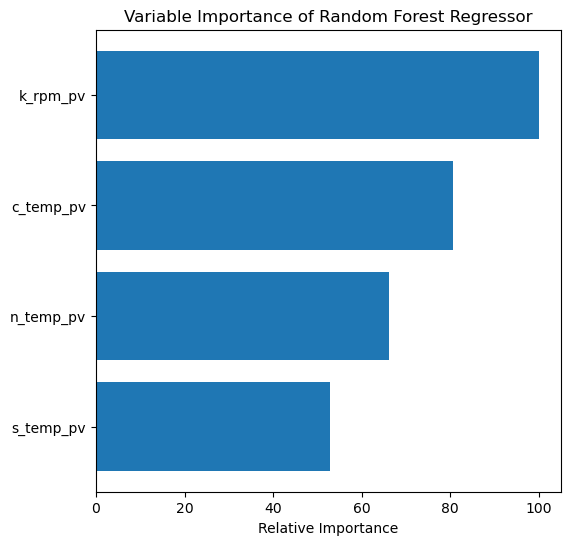

In [ ]:
# Feature Importance
import matplotlib.pyplot as plt

rfr = RFR(n_estimators=230, min_samples_split=25, max_features=0.215)
rfr.fit(X_train, y_train)
feature_importance = rfr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance of Random Forest Regressor')
plt.show()

